In [1]:
import numpy as np
from matplotlib import pyplot
from numba import njit, vectorize

First we define some parameters for our system

In [2]:
kappa = 20
lamda = 0.005
rho = 0.005
mu = 0.02
mean_s = kappa / lamda
mean_x = mean_s * rho / mu
mean_s, mean_x

(4000.0, 1000.0)

In [3]:
@njit(fastmath=True)
def corr_ss(t):
    return mean_s * np.exp(-np.abs(t) * lamda)

@njit(fastmath=True)
def corr_xs_(t):
    return rho * mean_s / (lamda + mu) * np.exp(-lamda * t)

@njit(fastmath=True)
def corr_sx_(t):
    a = rho * mean_s / (lamda - mu)
    b1 = (1 + (lamda - mu)/(lamda + mu))*np.exp(-mu * t)
    b2 = - np.exp(-lamda * np.abs(t))
    return a * (b1 + b2)

@njit(fastmath=True)
def corr_xs(t):
    return np.where(t >= 0, corr_xs_(t), corr_sx_(-t))

@njit(fastmath=True)
def corr_sx(t):
    return np.where(t >= 0, corr_sx_(t), corr_xs_(-t))

@njit(fastmath=True)
def corr_xx(t):
    c1 = np.exp(-mu * np.abs(t)) - np.exp(-lamda * np.abs(t))
    c2 = np.exp(-mu * np.abs(t))
    d1 = rho**2 / (lamda**2 - mu**2) * mean_s
    d2 = (1+rho/(lamda-mu))*mean_x
    return (d1*c1 + d2*c2)

@njit(fastmath=True)
def time_matrix(N, delta_t):
    time_stamps = np.expand_dims(np.arange(0, N, delta_t), 0)
    return time_stamps - time_stamps.T

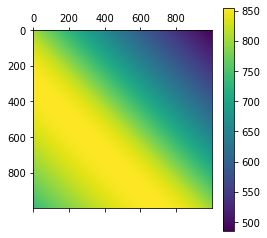

In [4]:
t = time_matrix(100, 0.1)
c_ss = corr_ss(t)
c_sx = corr_sx(t)
c_xs = corr_xs(t)
c_xx = corr_xx(t)
pyplot.matshow(c_xs)
pyplot.colorbar();


In [28]:
@njit
def mutual_information_from_matrix(t):
    c_ss = corr_ss(t)
    c_sx = corr_sx(t)
    c_xs = corr_xs(t)
    c_xx = corr_xx(t)
    
    sign, det_c_ss = np.linalg.slogdet(c_ss)
    assert sign == 1
    sign, det_c_xx = np.linalg.slogdet(c_xx)
    assert sign == 1
    
    ns = c_ss.shape[0]
    nx = c_xx.shape[0]
    z = np.empty((ns + nx, ns + nx))    
    z[:ns, :ns] = c_ss
    z[:ns, ns:] = c_xs
    z[ns:, :ns] = c_sx
    z[ns:, ns:] = c_xx
    
    sign, det_z = np.linalg.slogdet(z)
    assert sign == 1
                
    return 0.5 * (det_c_ss + det_c_xx - det_z)

In [29]:
@vectorize
def mutual_information(L, delta_t):
    return mutual_information_from_matrix(time_matrix(L, delta_t))

In [35]:
(mutual_information(2500, 0.5) - mutual_information(2000, 0.5)) / 500

0.0019286680053410238

In [ ]:
x = np.geomspace(0.1, 10, 10)
pyplot.plot(x, mutual_information(1000, x) - mutual_information(800, x));

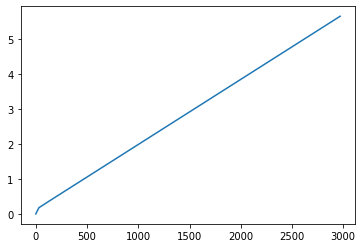

In [23]:
x = np.arange(0, 3000, 30)
pyplot.plot(x, mutual_information(x, 10));

In [26]:
mutual_information(x, 1)

array([0.        , 0.19539714, 0.25458964, 0.31318882, 0.37144066,
       0.42948886, 0.48741757, 0.54527612, 0.60309347, 0.66088662,
       0.71866556, 0.77643614, 0.83420182, 0.89196462, 0.94972572,
       1.00748583, 1.06524535, 1.12300453, 1.18076351, 1.23852237,
       1.29628116, 1.35403991, 1.41179863, 1.46955734, 1.52731605,
       1.58507474, 1.64283344, 1.70059213, 1.75835082, 1.81610952,
       1.87386821, 1.9316269 , 1.98938559, 2.04714428, 2.10490297,
       2.16266166, 2.22042035, 2.27817904, 2.33593773, 2.39369642,
       2.45145511, 2.5092138 , 2.56697249, 2.62473118, 2.68248988,
       2.74024857, 2.79800726, 2.85576595, 2.91352464, 2.97128333,
       3.02904202, 3.08680071, 3.1445594 , 3.20231809, 3.26007678,
       3.31783547, 3.37559416, 3.43335285, 3.49111154, 3.54887023,
       3.60662892, 3.66438762, 3.72214631, 3.779905  , 3.83766369,
       3.89542238, 3.95318107, 4.01093976, 4.06869845, 4.12645714,
       4.18421583, 4.24197452, 4.29973321, 4.3574919 , 4.41525